# 提出用Notebook

以下が私の解答です。

In [1]:
from tensorVis import vis2dTensorKarnaugh,\
                        vis4dTensorKarnaugh,\
                        vis4dTensorNest,\
                        vis6dTensorKarnaugh
from kRDM import fast_compute_one_rdm,\
                 fast_compute_two_rdm
from wedgeProduct import fast_wedge

以下動作確認の為、渡されたNotebookの流れに従って、同じ結果が得られることを確認します。

In [2]:
import openfermion
#from openfermion import ran
import numpy as np
n_qubit = 6
n_electrons = 3

def is_particle_number_correct(arg: int, n_qubit: int, n_particle: int):
    l = bin(arg)[2:].zfill(n_qubit)
    return sum([int(b) for b in l]) == n_particle

# generate Haar random state
np.random.seed(1234)
vec_6q = np.random.normal(size = 2**n_qubit) + 1j * np.random.normal(size = 2**n_qubit)
vec_10q = np.random.normal(size = 2**10) + 1j * np.random.normal(size = 2**10)

# particle number restriction
vec_6q = [vec_6q[i] if is_particle_number_correct(i, 6, n_electrons) else 0 for i in range(2**6)]
vec_6q /= np.linalg.norm(vec_6q)

vec_10q = [vec_10q[i] if is_particle_number_correct(i, 10, n_electrons) else 0 for i in range(2**10)]
vec_10q /= np.linalg.norm(vec_10q)

## compute k-RDM

フェルミオン系の量子多体状態$\rho$に対して、その$k$-RDM (Reduced Density Matrix, 縮約密度行列)の行列要素を
\begin{align}
^k D^{p_1\cdots p_k}_{q_1 \cdots q_k} = \mathrm{Tr}[c_{p_1}^\dagger \cdots c_{p_k}^\dagger c_{q_1}\cdots c_{q_k} \rho]
\end{align}
により定義することにする。ここで、 $c_i^{(\dagger)}$は$i$番目のフェルミオンに関する消滅(生成)演算子を表す。

In [3]:
from openfermion import FermionOperator, get_sparse_operator

def expectation(operator, state):
    n_qubit = int(np.log2(state.shape[0]))
    if type(operator) == np.ndarray:
        return state.conj() @ operator @ state
    else:
        return state.conj() @ get_sparse_operator(operator, n_qubits = n_qubit).toarray() @ state

    
from sympy.combinatorics import Permutation

def get_sign_of_args(args):
    if len(args) - len(np.unique(args)) > 0:
        return 0
    order = [list(args).index(arg) for arg in np.sort(args)]
    return Permutation(order).signature()

def get_corresponding_index(args: tuple):
    k = len(args)//2
    assert len(args) == 2*k
    args_ = list(args)
    
    args1 = args_[:k]
    args2 = args_[k:]
    
    sign1 = get_sign_of_args(args1)
    sign2 = get_sign_of_args(args2)
    
    argmin1 = min(args1)
    argmin2 = min(args2)
        
    if_conjugate = argmin1 > argmin2
    if if_conjugate:
        args1_ref =  sorted(args2)
        args2_ref = sorted(args1)
    else:
        args1_ref = sorted(args1)
        args2_ref = sorted(args2)
    return tuple(args1_ref + args2_ref), if_conjugate, sign1 * sign2


def compute_one_rdm(vector: np.ndarray):
    n_qubit = int(np.log2(vector.shape[0]))
    rdm1 = np.zeros((n_qubit, n_qubit), dtype = complex)
    for i in range(n_qubit):
        for j in range(i, n_qubit):
            cij = expectation(FermionOperator(f"{i}^ {j}"), vector)
            
            rdm1[i, j] = np.copy(cij)
            rdm1[j, i] = np.copy(cij).conj()
    return rdm1.copy()

def compute_two_rdm(vector: np.ndarray):
    n_qubit = int(np.log2(vector.shape[0]))
    rdm2 = np.zeros((n_qubit, n_qubit, n_qubit, n_qubit), dtype = complex)
    for i in range(n_qubit):
        for j in range(i, n_qubit):
            for k in range(j, n_qubit):
                for l in range(k, n_qubit):
                    
                    unique_args = list(set([(i, j, k, l), (i, k, j, l), (i, l, j, k)]))
                    for _args in unique_args:
                        exp = expectation(FermionOperator(f"{_args[0]}^ {_args[1]}^ {_args[2]} {_args[3]}"), vector)
                        rdm2[_args] = exp

    for i in range(n_qubit):
        for j in range(n_qubit):
            for k in range(n_qubit):
                for l in range(n_qubit):
                    
                    
                    args = (i, j, k, l)
                    args_ref, if_conjugate, sign = get_corresponding_index(args)
        
                    cijkl = np.copy(rdm2[args_ref]) * sign
                    if if_conjugate:
                        cijkl = cijkl.conj()

                    rdm2[i, j, k, l] = np.copy(cijkl)     
    return rdm2.copy()

In [4]:
rdm1 = compute_one_rdm(vec_6q)
rdm2 = compute_two_rdm(vec_6q)

In [5]:
# to be honest this is already slow
rdm1_10q = compute_one_rdm(vec_10q)
rdm2_10q = compute_two_rdm(vec_10q)

**以下が確認セル**

In [6]:
fast_rdm1=fast_compute_one_rdm(vec_6q)
fast_rdm2=fast_compute_two_rdm(vec_6q)
fast_rdm1_10q=fast_compute_one_rdm(vec_10q)
fast_rdm2_10q=fast_compute_two_rdm(vec_10q)
assert np.allclose(rdm1,fast_rdm1)
assert np.allclose(rdm2,fast_rdm2)
assert np.allclose(rdm1_10q,fast_rdm1_10q)
assert np.allclose(rdm2_10q,fast_rdm2_10q)

In [7]:
# openfermion内部では、2-RDMに定数倍をかけたものを活用している
tpdm = rdm2 / 2
tpdm_10q = rdm2_10q / 2

# openfermion内部では、1-RDMに定数倍をかけたものを活用している
opdm = (2 / (n_electrons - 1)) * np.einsum('ijjk', tpdm)
opdm_10q = (2 / (n_electrons - 1)) * np.einsum('ijjk', tpdm_10q)

In [8]:
# n-qubit系 (n-fermion mode系)では shape = (N, N)
opdm.shape

(6, 6)

In [9]:
# n-qubit系 (n-fermion mode系)では shape = (N, N, N, N)
tpdm.shape

(6, 6, 6, 6)

## wedge product of tensors



Wedge積は、反交換関係を保つようなKronecker deltaのようなものだと理解できる。
その定義は、以下のように与えられる：
\begin{align}
     \left( a \wedge b\right) ^{i_{1}, i_{2}, ..., i_{p},..., i_{p+q}}_{j_{1}, j_{2}, ...,j_{p}, ..., j_{p+q} } =
    \left(\frac{1}{N!}\right)^{2} 
\sum_{\pi, \sigma}
    \epsilon(\pi)
    \epsilon(\sigma)
    a_{\pi(j_{1}), \pi(j_{2}), ..., \pi(j_{p}) }^{ \sigma(i_{1}), \sigma(i_{2}), ..., \sigma(i_{p})}
    b_{\pi(j_{p+1}), \pi(j_{p+2}), ..., \pi(j_{p+q}) }^{ \sigma(i_{p+1}), \sigma(i_{p+2}), ..., \sigma(i_{p+q})}
    \end{align}
    ただし、$a$と$b$はそれぞれ $p$-RDM, $q$-RDMを表すテンソルで、フェルミオンの半交換関係に起因して行列要素同士が符号で結びついている。
    また、$\pi, \sigma$はそれぞれ $(p+q)$個の添字に関する巡回を表し、$\epsilon(\pi)$などは巡回操作の符号を表すものとする。
    
その素朴なeinsumによる実装は、googleの提供する Openfermionライブラリに提供されているが、例によって遅くて困っている。
`wedge`関数の[URL](https://quantumai.google/reference/python/openfermion/linalg/wedge) 

In [10]:
from openfermion.linalg import wedge

# 上記の操作をまとめたのが `wedge`関数である
left_index_ranks = (1, 1)
right_index_ranks = (2, 2)
thpdm = wedge(opdm, tpdm, left_index_ranks, right_index_ranks)

~~以下では、 `wedge`の実装部分を分解し、その動作を理解する。~~

省略

## 実行時間テスト

(4, 4)階のテンソルの生成に時間がかかりすぎている。

In [11]:
# this is fine
unconnected_tpdm = wedge(opdm, opdm, (1, 1), (1,1))

In [12]:
# this is okay
unconnected_d3 = wedge(opdm, tpdm, (1, 1), (2, 2))

In [13]:
# generating (4, 4) tensor is too slow, even for 6 qubits
unconnected_d4 = wedge(tpdm, tpdm, (2, 2), (2, 2))

In [14]:
# this is the case for other calculations as well
unconnected_d4_2 = wedge(opdm, unconnected_d3, (1, 1), (3, 3))

### 10-qubit

In [15]:
# this is becoming irritating
unconnected_d3_10q = wedge(opdm_10q, tpdm_10q, (1, 1), (2, 2))

In [16]:
# # slow as hell
# unconnected_d4_10q = wedge(opdm_10q, unconnected_d3_10q, (1, 1), (3, 3))

**以下が確認セル**

In [17]:
fast_unconnected_tpdm = fast_wedge(opdm, opdm, (1, 1), (1, 1))
fast_unconnected_d3 = fast_wedge(opdm, tpdm, (1, 1), (2, 2))
fast_unconnected_d4 = fast_wedge(tpdm, tpdm, (2, 2), (2, 2))
fast_unconnected_d4_2 = fast_wedge(opdm, fast_unconnected_d3, (1, 1), (3, 3))
fast_unconnected_d3_10q = fast_wedge(opdm_10q, tpdm_10q, (1, 1), (2, 2))
assert np.allclose(unconnected_tpdm, fast_unconnected_tpdm)
assert np.allclose(unconnected_d3, fast_unconnected_d3)
assert np.allclose(unconnected_d4, fast_unconnected_d4)
assert np.allclose(unconnected_d4_2, fast_unconnected_d4_2)
assert np.allclose(unconnected_d3_10q, fast_unconnected_d3_10q)

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/14400 [00:00<?, ?it/s]

In [18]:
fast_unconnected_d4_10q = fast_wedge(opdm_10q, fast_unconnected_d3_10q, (1, 1), (3, 3))


  0%|          | 0/44100 [00:00<?, ?it/s]

In [19]:
print("sugoi hayai program")

sugoi hayai program


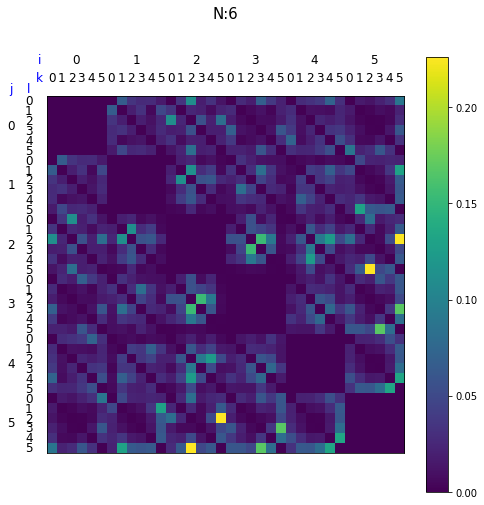

In [20]:
vis4dTensorNest(fast_unconnected_tpdm)